In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [19]:
from pathlib import Path
import cv2

In [28]:
import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
import torch
torch.cuda.set_device(0)

In [5]:
torch.backends.cudnn.benchmark=True

In [24]:
import pandas as pd
import numpy as np

In [10]:
PATH = Path(r'g:\open-images')

In [83]:
H, W = 224, 224

In [14]:
class_desc = pd.read_csv(PATH/'challenge-2018-class-descriptions-500.csv', header=None, names=['class', 'class_name'])

In [15]:
class_desc.head()

,class,class_name
0,/m/061hd_,Infant bed
1,/m/06m11,Rose
2,/m/03120,Flag
3,/m/01kb5b,Flashlight
4,/m/0120dh,Sea turtle


In [36]:
img_class = pd.read_csv(PATH/'challenge-2018-train-annotations-human-imagelabels.csv')
img_class.head()

,ImageID,Source,LabelName,Confidence
0,79f4fdf91ab44345,verification,/m/01mqdt,1
1,39f88921c49c1ff8,verification,/m/02wbtzl,1
2,0b605798b08c1124,verification,/m/0jyfg,1
3,37f76516e5753fa4,verification,/m/0hg7b,0
4,9bb59e22352594e9,verification,/m/01226z,1


In [82]:
bbox = pd.read_csv(PATH/'challenge-2018-train-annotations-bbox.csv')
bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,8d6dec80235b6fea,xclick,/m/09j5n,1,0.760000,0.778125,0.645892,0.673277,0,0,0,0,0
1,8d6dec80235b6fea,xclick,/m/09j5n,1,0.817500,0.831875,0.628895,0.661945,0,0,0,0,0
2,8d6dec80235b6fea,xclick,/m/09j5n,1,0.843125,0.870000,0.619452,0.645892,0,0,0,0,0
3,8d6dec80235b6fea,xclick,/m/09j5n,1,0.867500,0.891875,0.597734,0.625118,0,0,0,0,0
4,8d6dec80235b6fea,xclick,/m/09j5n,1,0.895625,0.911250,0.625118,0.656280,0,0,0,0,0


In [109]:
def get_img_classes(img_id):
    df1 = img_class[img_class['Confidence'] == 1]
    return [str(item) for item in df1[df1['ImageID'] == img_id]['LabelName']]

def get_img_labels(img_id):
    classes = get_img_classes(img_id)
    return [class_desc[class_desc['class'] == cls]['class_name'].values[0] for cls in classes]

def get_bbox(img_id):
    df1 = bbox[bbox['Confidence'] == 1]
    df1 = df1[df1['ImageID'] == img_id]
    v = df1.values
    return [([int(r[4]*W), int(r[6]*W), int(r[5]*H) - int(r[4]*H), int(r[7]*H) - int(r[6]*H)], r[2]) for r in v]

In [110]:
get_bbox('000002b66c9c498e')

[([2, 33, 41, 98], '/m/01g317'),
 ([5, 159, 56, 53], '/m/01g317'),
 ([33, 44, 36, 88], '/m/01g317'),
 ([57, 145, 39, 62], '/m/01g317'),
 ([57, 52, 20, 34], '/m/01g317'),
 ([71, 58, 11, 15], '/m/01g317'),
 ([92, 26, 119, 80], '/m/01g317'),
 ([14, 199, 96, 23], '/m/04bcr3'),
 ([67, 103, 154, 30], '/m/04bcr3'),
 ([70, 78, 59, 25], '/m/04bcr3'),
 ([117, 149, 90, 70], '/m/0fszt')]

In [78]:
get_img_classes('000002b66c9c498e')

['/m/04bcr3', '/m/0fszt', '/m/01g317']

In [79]:
get_img_labels('000002b66c9c498e')

['Table', 'Cake', 'Person']

In [71]:
train0_files = list((PATH/'train_0').glob('*.jpg'))
print(len(train0_files))
train0_files[:3]

156541


[WindowsPath('g:/open-images/train_0/000002b66c9c498e.jpg'),
 WindowsPath('g:/open-images/train_0/000002b97e5471a0.jpg'),
 WindowsPath('g:/open-images/train_0/000002c707c9895e.jpg')]

In [62]:
filenames = [str(f) for f in train0_files][:1000]
imgs = [cv2.resize(cv2.imread(fn), (H,W)) for fn in filenames]
filenames[:2]

['g:\\open-images\\train_0\\000002b66c9c498e.jpg',
 'g:\\open-images\\train_0\\000002b97e5471a0.jpg']

In [31]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

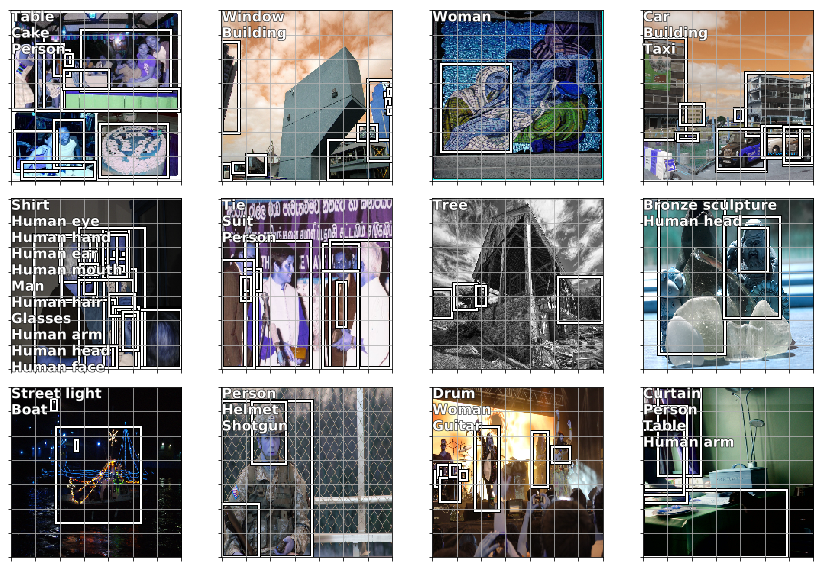

In [111]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    img_id = filenames[i].split('\\')[-1].split('.')[0]
    title = '\n'.join(get_img_labels(img_id))
    ax = show_img(imgs[i], ax=ax)
    draw_text(ax, (0,0), title)
    bb = get_bbox(img_id)
    for b in bb:
        draw_rect(ax, b[0])
plt.tight_layout()

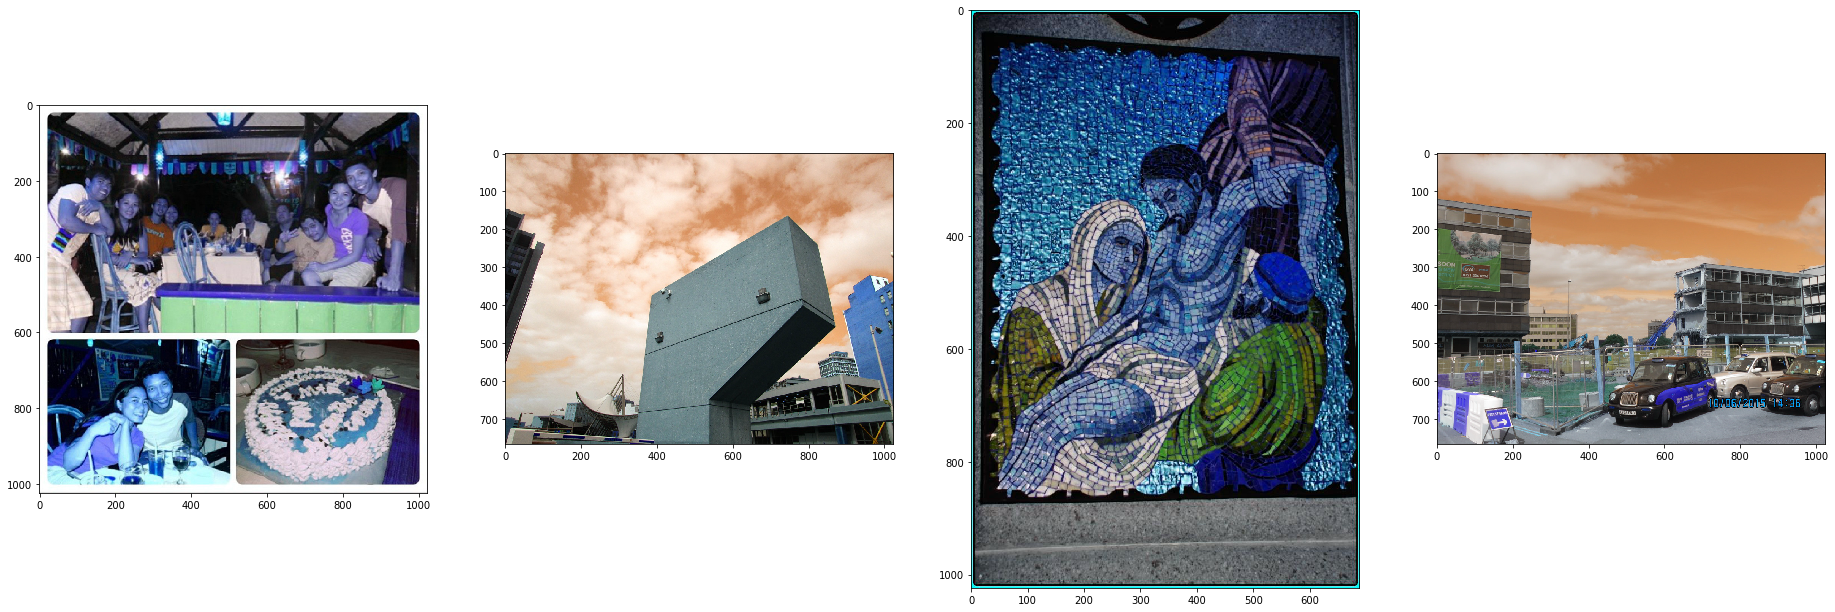

In [29]:
plt.figure(figsize=(32,32))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs[i])

In [ ]:
PATH = Path(r'g:\open-images')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS